In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
from astropy.cosmology import FlatLambdaCDM

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})

In [3]:
orbit = {}
for i in [33,40,50]:
    orbit[i] = {}
    f = h5py.File(f"{paths.path_data}big-bad/massive_orbitdata_{i}.hdf5",'r')
    for key, val in f.items():
        orbit[i][key] = np.array(val)
    f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
convert = {}
for key, val in f.items():
    convert[key] = np.array(val)
f.close()

## Histogram of amount of time spent in a separation bin

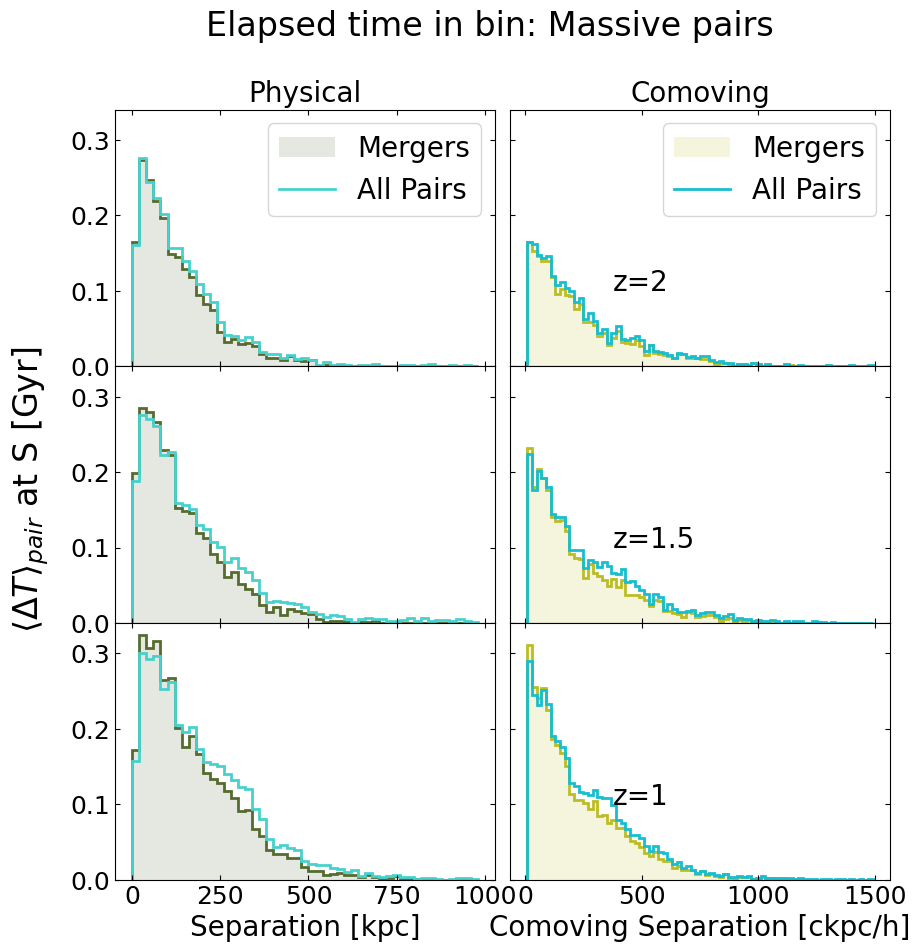

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.04,
                                    "hspace":0.0})
z={"33":"z=2","40":"z=1.5","50":"z=1"}
little_h = 0.6774

for ii, snap in enumerate([33, 40, 50]):
    orb = orbit[snap]
    sep_matrix = orb["Separations"]
    elapsed_time = np.abs(np.diff(convert["Lookback Time"]))
    scales = convert['Scale'] # gives scale in same order as orbit data
    
    scale_matrix = np.tile(scales,(len(sep_matrix),1))
    sep_ckpcperh = sep_matrix/scale_matrix*little_h
    
    # array of the elapsed time with a nan value in the place of z=0
    elapsed_noz0 = np.concatenate((elapsed_time,np.array([0])))
    elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

    nan_elapsed = np.isnan(elapsed_matrix)
    nan_sep = np.isnan(sep_matrix)
    zero_sep = sep_matrix == 0
    lower_sep = sep_ckpcperh > 10
    matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep&lower_sep
    
    merger_array = np.array(orb["MergeFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(100,1)).transpose()

#     elapsed_masked = elapsed_matrix[matrix_mask]
#     sep_masked = sep_matrix[matrix_mask]

    ## calculate histograms
    xx_phys = sep_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
    xx_phys_all = sep_matrix[matrix_mask&orb['GroupFlag']]
    

    xx_comov = sep_ckpcperh[matrix_mask&merge_mask&orb['GroupFlag']]
    xx_comov_all = sep_ckpcperh[matrix_mask&orb['GroupFlag']]

    yy = elapsed_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
    yy_all = elapsed_matrix[matrix_mask&orb['GroupFlag']]

    num_mergers = sum(merger_array)
    num_pairs = len(merger_array) 
    bins_phys = np.arange(0,1000,20)
    bins_ckpch = np.arange(10,1500,20)

    phys, _ = np.histogram(xx_phys,bins=bins_phys,weights=yy/num_mergers)
    phys_all, _ = np.histogram(xx_phys_all,bins=bins_phys,weights=yy_all/num_pairs)
    comov, _ = np.histogram(xx_comov,bins=bins_ckpch,weights=yy/num_mergers)
    comov_all, _ = np.histogram(xx_comov_all,bins=bins_ckpch,weights=yy_all/num_pairs)    
    
    ax[ii][0].stairs(phys,bins_phys,color="darkolivegreen",lw=2,alpha=0.15,fill=True,label="Mergers")
    ax[ii][0].stairs(phys,bins_phys,color="darkolivegreen",lw=2)
    ax[ii][0].stairs(phys_all,bins_phys,color="mediumturquoise",lw=2,label='All Pairs')
    
    ax[ii][1].stairs(comov,bins_ckpch,color="tab:olive",lw=2,alpha=0.15,fill=True,label="Mergers")
    ax[ii][1].stairs(comov,bins_ckpch,color="tab:olive",lw=2)
    ax[ii][1].stairs(comov_all,bins_ckpch,color="tab:cyan",lw=2,label='All Pairs')
    
    ax[ii][1].text(375,0.1,f"{z[str(snap)]}")

    
#     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,alpha=0.15,fill=True)
#     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,label="Merged")
#     ax[ii].stairs(all_vals,all_edges,color="tab:cyan",lw=2,label="Group & lower phys sep",)
# #     ax[ii].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=2,label="Unmerged")
    
#     ax[ii].text(0,1,f"{z[str(snap)]}")
#     ax[ii].text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
#     ax[ii].text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")
    
    
ax[0][0].set_title("Physical",fontsize=20)
ax[0][1].set_title("Comoving",fontsize=20)

ax[2][0].set_xlabel("Separation [kpc]")
ax[2][1].set_xlabel("Comoving Separation [ckpc/h]")

ax[0][0].legend()
ax[0][1].legend()

ax[0][0].legend()

fig.suptitle("Elapsed time in bin: Massive pairs")
# fig.supxlabel("Separation S [kpc]",y=0.05)
fig.supylabel(r"$\left< \Delta T\right>_{pair}$ at S [Gyr]")
plt.savefig(f"{paths.path_plots}big-bad/timevssep_z.pdf")
plt.show()


## Cumulative time spent

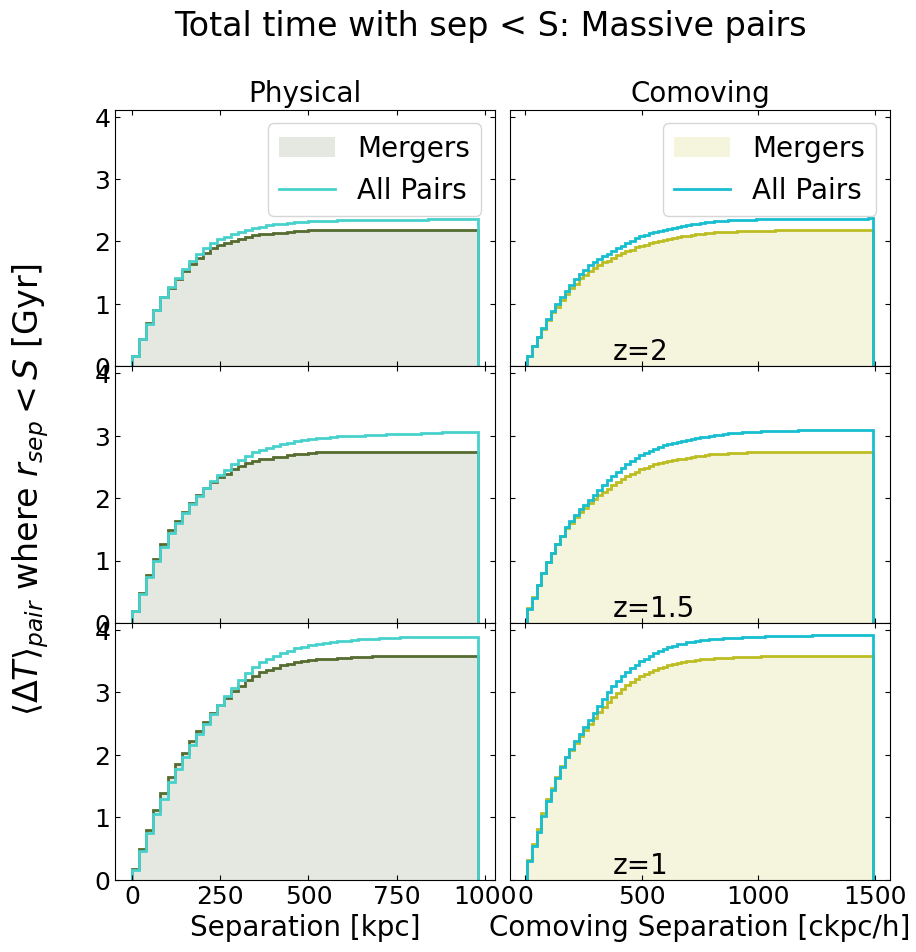

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.04,
                                    "hspace":0.0})
z={"33":"z=2","40":"z=1.5","50":"z=1"}
little_h = 0.6774

for ii, snap in enumerate([33, 40, 50]):
    orb = orbit[snap]
    sep_matrix = orb["Separations"]
    elapsed_time = np.abs(np.diff(convert["Lookback Time"]))
    scales = convert['Scale'] # gives scale in same order as orbit data
    
    scale_matrix = np.tile(scales,(len(sep_matrix),1))
    sep_ckpcperh = sep_matrix/scale_matrix*little_h
    
    # array of the elapsed time with a nan value in the place of z=0
    elapsed_noz0 = np.concatenate((elapsed_time,np.array([0])))
    elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

    nan_elapsed = np.isnan(elapsed_matrix)
    nan_sep = np.isnan(sep_matrix)
    zero_sep = sep_matrix == 0
    lower_sep = sep_ckpcperh > 10
    matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep&lower_sep
    
    merger_array = np.array(orb["MergeFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(100,1)).transpose()

#     elapsed_masked = elapsed_matrix[matrix_mask]
#     sep_masked = sep_matrix[matrix_mask]

    ## calculate histograms
    xx_phys = sep_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
    xx_phys_all = sep_matrix[matrix_mask&orb['GroupFlag']]
    

    xx_comov = sep_ckpcperh[matrix_mask&merge_mask&orb['GroupFlag']]
    xx_comov_all = sep_ckpcperh[matrix_mask&orb['GroupFlag']]

    yy = elapsed_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
    yy_all = elapsed_matrix[matrix_mask&orb['GroupFlag']]

    num_mergers = sum(merger_array)
    num_pairs = len(merger_array) 
    bins_phys = np.arange(0,1000,20)
    bins_ckpch = np.arange(10,1500,20)

    phys, _ = np.histogram(xx_phys,bins=bins_phys,weights=yy/num_mergers)
    phys_all, _ = np.histogram(xx_phys_all,bins=bins_phys,weights=yy_all/num_pairs)
    comov, _ = np.histogram(xx_comov,bins=bins_ckpch,weights=yy/num_mergers)
    comov_all, _ = np.histogram(xx_comov_all,bins=bins_ckpch,weights=yy_all/num_pairs)    
    
    ax[ii][0].stairs(np.cumsum(phys),bins_phys,color="darkolivegreen",lw=2,alpha=0.15,fill=True,label="Mergers")
    ax[ii][0].stairs(np.cumsum(phys),bins_phys,color="darkolivegreen",lw=2)
    ax[ii][0].stairs(np.cumsum(phys_all),bins_phys,color="mediumturquoise",lw=2,label='All Pairs')
    
    ax[ii][1].stairs(np.cumsum(comov),bins_ckpch,color="tab:olive",lw=2,alpha=0.15,fill=True,label="Mergers")
    ax[ii][1].stairs(np.cumsum(comov),bins_ckpch,color="tab:olive",lw=2)
    ax[ii][1].stairs(np.cumsum(comov_all),bins_ckpch,color="tab:cyan",lw=2,label='All Pairs')
    
    ax[ii][1].text(375,0.1,f"{z[str(snap)]}")

    
#     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,alpha=0.15,fill=True)
#     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,label="Merged")
#     ax[ii].stairs(all_vals,all_edges,color="tab:cyan",lw=2,label="Group & lower phys sep",)
# #     ax[ii].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=2,label="Unmerged")
    
#     ax[ii].text(0,1,f"{z[str(snap)]}")
#     ax[ii].text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
#     ax[ii].text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")
    
    
ax[0][0].set_title("Physical",fontsize=20)
ax[0][1].set_title("Comoving",fontsize=20)

ax[2][0].set_xlabel("Separation [kpc]")
ax[2][1].set_xlabel("Comoving Separation [ckpc/h]")

ax[0][0].legend()
ax[0][1].legend()

ax[0][0].legend()
fig.suptitle("Total time with sep < S: Massive pairs")
# fig.suptitle("Timescales for major dwarf pairs",y=0.92)
# fig.supxlabel("Separation S [kpc]",y=0.05)
fig.supylabel(r"$\left< \Delta T\right>_{pair}$ where $r_{sep}<S$ [Gyr]")
plt.savefig(f"{paths.path_plots}big-bad/cumulative-timevssep_z.pdf")
plt.show()
